In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from fastai2.vision.all import load_image, get_image_files, show_image, \
    show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from htools import *
from img_wang.torch_utils import *

/Users/hmamin/anaconda3/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [3]:
cd_root()
gpu_setup()

Current directory: /Users/hmamin/img_wang
Setting seeds for reproducible training.


/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:84: UserWarning: Cuda not available.
  if not torch.cuda.is_available(): warnings.warn('Cuda not available.')
/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:85: UserWarning: Incendio device is not cuda.
  if DEVICE.type != 'cuda': warnings.warn('Incendio device is not cuda.')


In [69]:
class AlbumentationsDataset(Dataset):

    @valuecheck
    def __init__(self, dir_=None, paths=(), shape=(128, 128), pct_pos=.5,
                 tfm='ChannelShuffle', **tfm_kwargs):
        if not dir_ and not paths:
            raise ValueError('One of dir_ or paths should be non-null.')

        self.paths = paths or get_image_files(dir_)
        self.shape = shape
        self.pct_pos = pct_pos
        self.load_img = load_image
        self.tfm = getattr(A, tfm)(always_apply=True, **tfm_kwargs)
        self.tfm_pipeline = A.Compose([A.Resize(*shape),
                                       ToTensorV2()])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        """
        1 if patch is from the original image, 0 otherwise.
        """
        x = np.array(self.load_img(self.paths[i]))
        if len(x.shape) == 2: 
            print('BEFORE', x.shape)
            x = np.repeat(x[..., None], 3, axis=2)
            print('AFTER', x.shape)
        y = 0
        if np.random.uniform() < self.pct_pos:
            x = self.tfm(image=x)['image']
            y = 1
        return self.tfm_pipeline(image=x)['image']/255.0, y

In [70]:
paths = get_image_files('data/imagewang-160/unsup')[:128]

In [71]:
ds = AlbumentationsDataset(paths=paths)
dl = DataLoader(ds, batch_size=8, shuffle=False)

0 [torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
1 [torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
2 [torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
3 [torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
4 [torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3

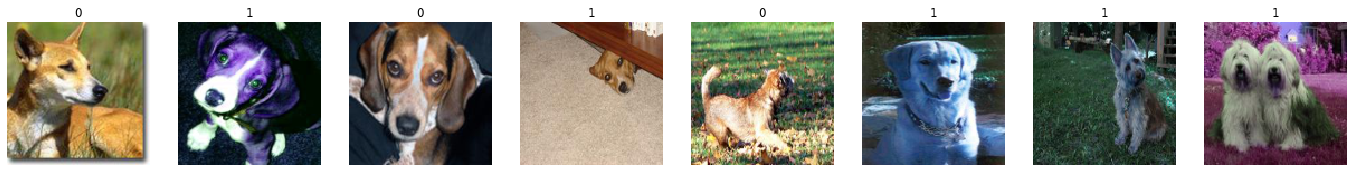

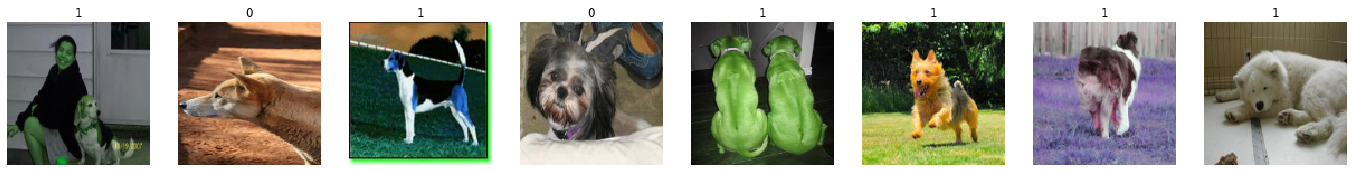

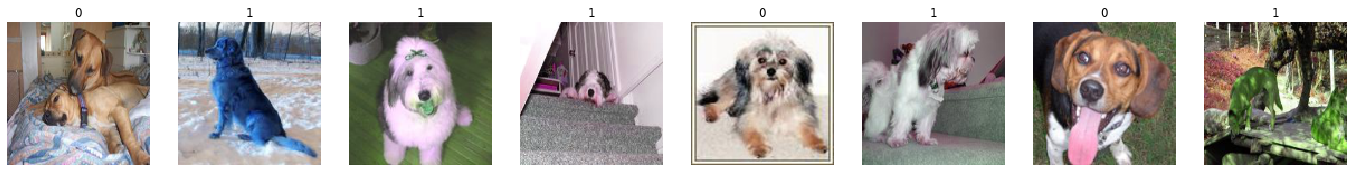

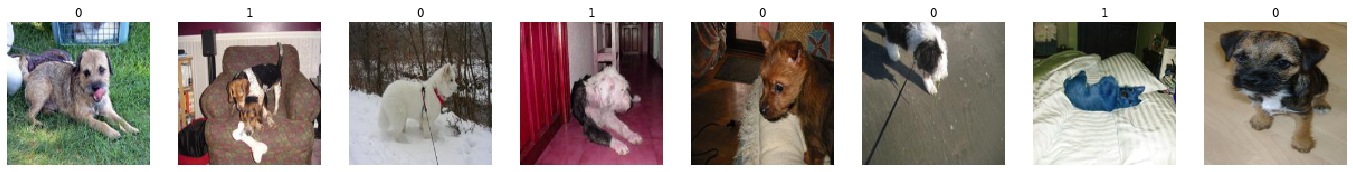

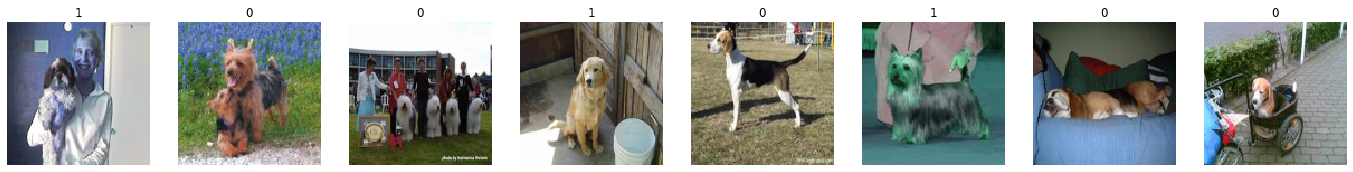

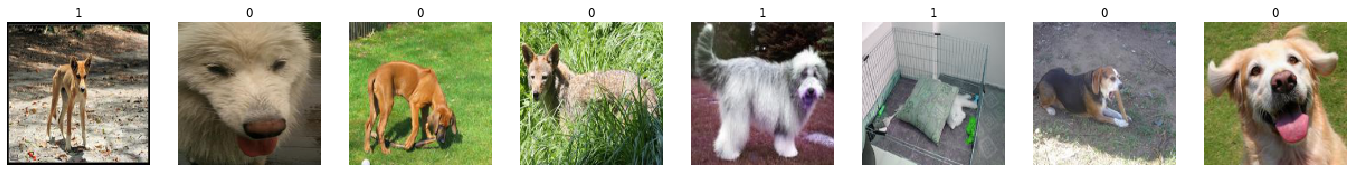

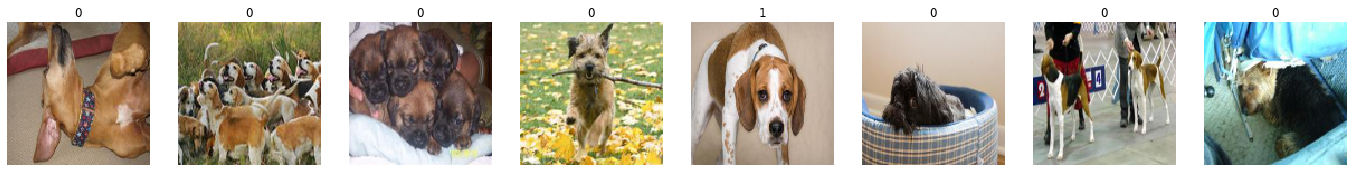

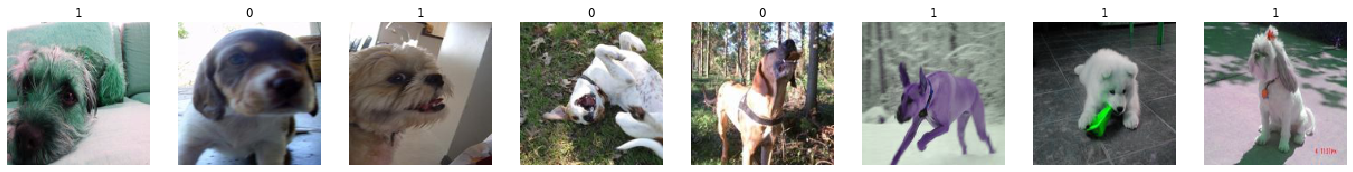

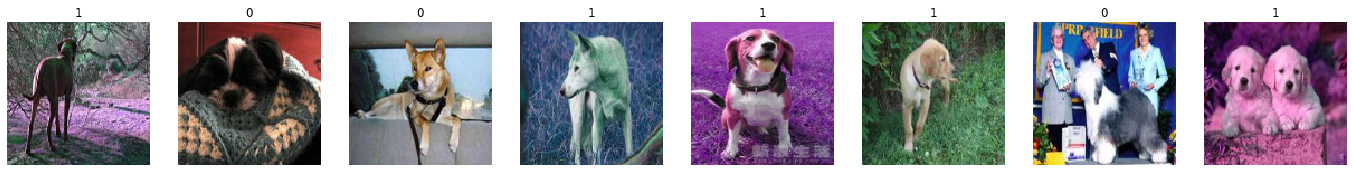

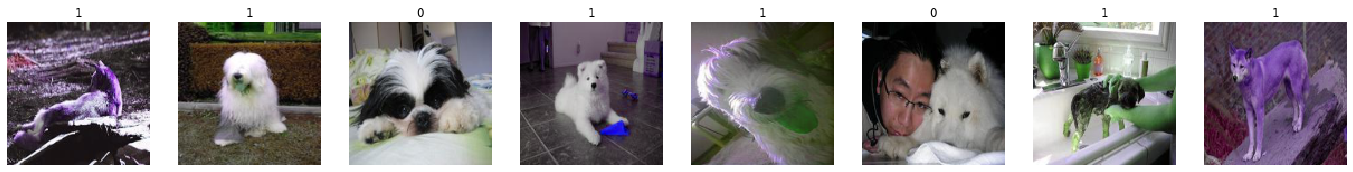

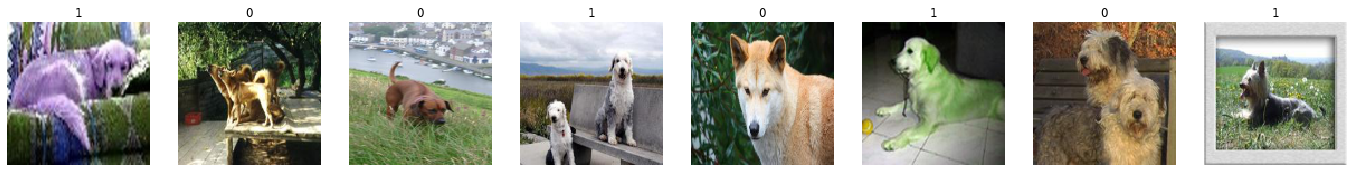

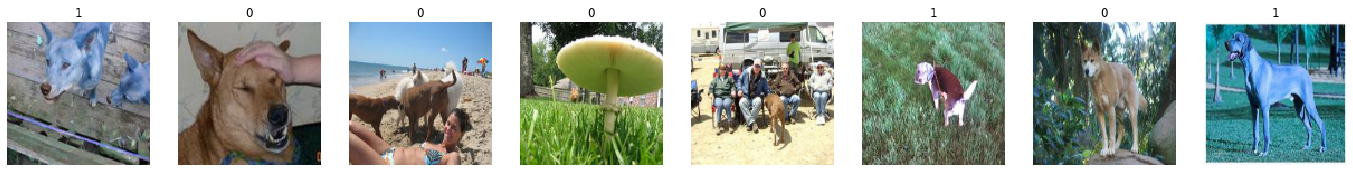

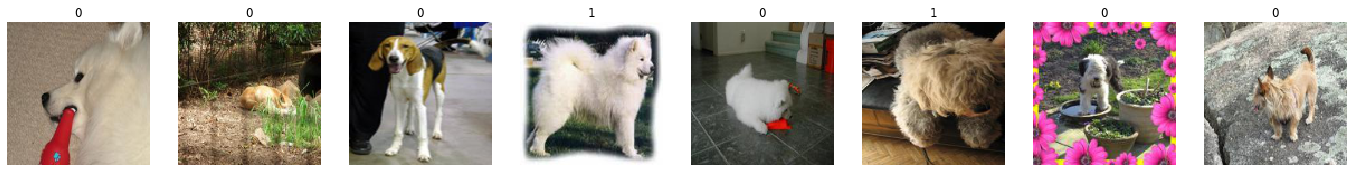

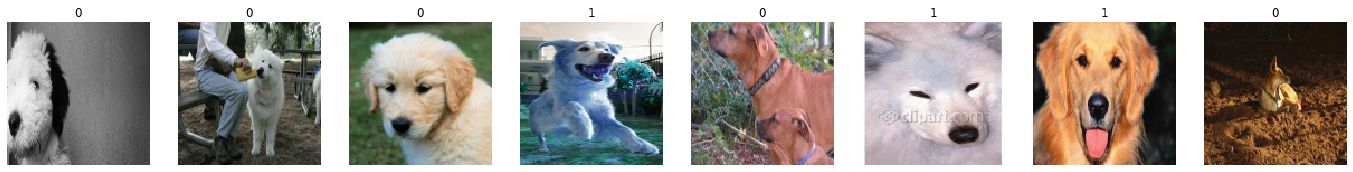

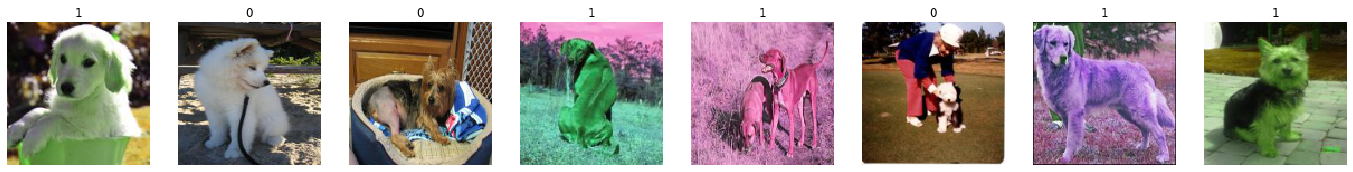

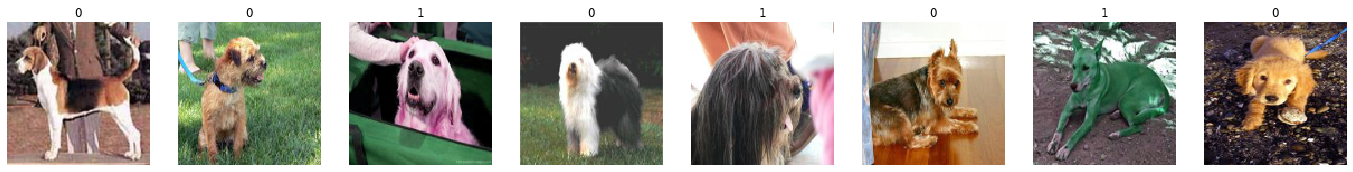

In [73]:
for i, (xb, yb) in enumerate(dl):
    xb = [x for x in xb.cpu()]
    print(i, [x.shape for x in xb])
    show_images(xb, titles=yb.cpu().numpy().tolist())
    if i > 24: break

In [77]:
ds[0][0].shape

torch.Size([3, 128, 128])

In [64]:
x = ds.load_img(ds.paths[104])
x_arr = np.array(x)
print(x_arr.shape)

x2 = ds.load_img(ds.paths[105])
x_arr2 = np.array(x2)
print(x_arr2.shape)

(160, 350)
(160, 213, 3)


In [66]:
x_arr.shape

(160, 350)

In [67]:
x3d = np.repeat(x_arr[..., None], 3, axis=2)
x3d.shape

(160, 350, 3)

In [68]:
ds.tfm_pipeline(image=x3d)['image'].shape

torch.Size([3, 128, 128])

In [74]:
A.Resize(128, 128)(image=x3d)['image'].shape

(128, 128, 3)